# Analyze RF mapping

In [2]:
#Import packages
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import scipy.stats as st
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
from sklearn import svm
import time

from DR_analysis_utils import Session, makePSTH, make_neuron_time_trials_tensor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib notebook

In [6]:
#Set paths to experiment folders
main_path = [
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\2022-08-15_11-22-28_626791\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\2022-08-16_12-43-07_626791\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\2022-08-17_13-25-06_626791\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-19_13-48-26_628801\processed",
    #add AM noise to RF mapping
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-26_12-48-09_636397\processed", 
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-27_11-37-08_636397\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-05_13-08-02_644547\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-06_12-35-35_644547\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\opto pilot\2022-11-07_12-31-20_635891\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\opto pilot\2022-11-08_11-03-58_635891\processed",
]


In [22]:
sel_session=8
session=Session(path=main_path[sel_session])

In [35]:
session.rf_trials

,Unnamed: 0,trialsX,trialsY,trialGratingOri,stimStartFrame,trialAMNoiseFreq,trialToneFreq,trialFullFieldContrast,trialStimType,stimStartTime,stimLatency
0,0,-479.233652,-146.240918,135.0,0,NaN,NaN,NaN,vis,116.070715,0.020685
1,1,-798.722753,146.240918,0.0,31,NaN,NaN,NaN,vis,116.587595,0.020685
2,2,-798.722753,-438.722753,315.0,62,NaN,NaN,NaN,vis,117.106385,0.022315
3,3,NaN,NaN,NaN,93,20.0,NaN,NaN,sound,117.635344,0.034104
4,4,479.233652,146.240918,135.0,124,NaN,NaN,NaN,vis,118.140635,0.022385
...,...,...,...,...,...,...,...,...,...,...,...
1651,1651,-798.722753,438.722753,45.0,51181,NaN,NaN,NaN,vis,969.799145,0.022585
1652,1652,NaN,NaN,NaN,51212,NaN,4000.0,NaN,sound,970.357112,0.063542
1653,1653,NaN,NaN,NaN,51243,0.0,NaN,NaN,sound,970.876887,0.066167
1654,1654,NaN,NaN,NaN,51274,NaN,NaN,0.0,vis,971.350440,0.022550


In [23]:
session.rf_trials.query('trialStimType == "sound"')

,Unnamed: 0,trialsX,trialsY,trialGratingOri,stimStartFrame,trialAMNoiseFreq,trialToneFreq,trialFullFieldContrast,trialStimType,stimStartTime,stimLatency
3,3,NaN,NaN,NaN,93,20.0,NaN,NaN,sound,117.635344,0.034104
6,6,NaN,NaN,NaN,186,NaN,16000.0,NaN,sound,119.215273,0.062833
9,9,NaN,NaN,NaN,279,NaN,12000.0,NaN,sound,120.765000,0.061250
10,10,NaN,NaN,NaN,310,40.0,NaN,NaN,sound,121.285298,0.064458
18,18,NaN,NaN,NaN,558,NaN,15000.0,NaN,sound,125.425621,0.068021
...,...,...,...,...,...,...,...,...,...,...,...
1646,1646,NaN,NaN,NaN,51026,40.0,NaN,NaN,sound,967.256912,0.065812
1648,1648,NaN,NaN,NaN,51088,NaN,13000.0,NaN,sound,968.286355,0.061125
1652,1652,NaN,NaN,NaN,51212,NaN,4000.0,NaN,sound,970.357112,0.063542
1653,1653,NaN,NaN,NaN,51243,0.0,NaN,NaN,sound,970.876887,0.066167


In [28]:
session.rf_trials.groupby('trialToneFreq').count()

,Unnamed: 0,trialsX,trialsY,trialGratingOri,stimStartFrame,trialAMNoiseFreq,trialFullFieldContrast,trialStimType,stimStartTime,stimLatency
trialToneFreq,,,,,,,,,,
4000.0,24,0,0,0,24,0,0,24,24,24
5000.0,24,0,0,0,24,0,0,24,24,24
6000.0,24,0,0,0,24,0,0,24,24,24
7000.0,24,0,0,0,24,0,0,24,24,24
8000.0,24,0,0,0,24,0,0,24,24,24
9000.0,24,0,0,0,24,0,0,24,24,24
10000.0,24,0,0,0,24,0,0,24,24,24
11000.0,24,0,0,0,24,0,0,24,24,24
12000.0,24,0,0,0,24,0,0,24,24,24


In [65]:
rf_trials_sound=session.rf_trials.query('trialStimType == "sound"')

sound_ID=[]
sound_freq=[]

for tt,trial in rf_trials_sound.iterrows():
    if ~np.isnan(trial['trialAMNoiseFreq']):
        sound_string='AM '+str(int(trial['trialAMNoiseFreq']))+' Hz'
        freq=trial['trialAMNoiseFreq']
    elif ~np.isnan(trial['trialToneFreq']):
        sound_string='Tone '+str(int(trial['trialToneFreq']/1000))+' kHz'
        freq=trial['trialToneFreq']
    else:
        sound_string=''
    sound_ID.append(sound_string)
    sound_freq.append(sound_freq)
    
rf_trials_sound['sound_ID']=sound_ID
rf_trials_sound['sound_freq']=sound_freq

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_8236\2248977700.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_trials_sound['sound_ID']=sound_ID
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_8236\2248977700.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_trials_sound['sound_freq']=sound_freq


In [34]:

np.unique(sound_ID)

array(['AM 0 Hz', 'AM 12 Hz', 'AM 20 Hz', 'AM 40 Hz', 'AM 80 Hz',
       'Tone 10 kHz', 'Tone 11 kHz', 'Tone 12 kHz', 'Tone 13 kHz',
       'Tone 14 kHz', 'Tone 15 kHz', 'Tone 16 kHz', 'Tone 4 kHz',
       'Tone 5 kHz', 'Tone 6 kHz', 'Tone 7 kHz', 'Tone 8 kHz',
       'Tone 9 kHz'], dtype='<U11')

In [37]:
# loop through sessions and make unit xarrays
time_before_flash = 0.25
trial_duration = 0.75
bin_size = 0.010


# Make tensor (3-D matrix [units,time,trials])
trial_tensor = make_neuron_time_trials_tensor(session.good_units, session.spike_times, 
                                              rf_trials_sound, time_before_flash, trial_duration, 
                                              bin_size)

# make xarray
session.trial_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                           coords={
                               "unit_id": session.good_units.index.values,
                               "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                               "trials": rf_trials_sound.index.values
                               })

In [48]:
session.trial_da.sel(unit_id=session.good_units.index[2]).values

array([[100., 100., 200., ..., 100., 200.,   0.],
       [100.,   0., 400., ...,   0., 100.,   0.],
       [  0.,   0.,   0., ...,   0., 100.,   0.],
       ...,
       [  0., 100.,   0., ..., 200., 400.,   0.],
       [  0., 100.,   0., ..., 200., 200.,   0.],
       [  0., 100., 100., ..., 400., 300., 200.]])

In [59]:
#make heatmaps

#Average & normalize responses of each unit to each stimulus

#find baseline mean and std per unit
baseline_mean_per_trial=session.trial_da.sel(time=slice(-0.25,-0.15)).mean(dim=["time"])
baseline_mean=baseline_mean_per_trial.mean(dim="trials").values
baseline_std=baseline_mean_per_trial.std(dim="trials").values

#find unique stimuli
stimuli = np.unique(sound_ID)

#pre-allocate array for average
unit_frs_by_stim = np.zeros((len(session.trial_da.unit_id),len(session.trial_da.time),len(stimuli)))

#normalize each unit's avg FRs to its baseline  FR
for ss,stim in enumerate(stimuli):
    stim_trials = rf_trials_sound.query('sound_ID == @stim').index.values
    unit_frs_by_stim[:,:,ss] = session.trial_da.sel(trials=stim_trials).mean(dim="trials").values
    
    # z-score each unit rel to its baseline
    unit_frs_by_stim[:,:,ss] = ((unit_frs_by_stim[:,:,ss].T- baseline_mean.T)/baseline_std.T).T

#Find/define probe borders for plotting
probe_borders=np.where(session.good_units['probe'].iloc[:-1].values!=session.good_units['probe'].iloc[1:].values)[0]
all_edges=np.hstack([0,probe_borders,len(session.good_units)])
midpoints=all_edges[:-1]+(all_edges[1:]-all_edges[:-1])/2
probe_labels=session.good_units['probe'].iloc[midpoints.astype('int')].values


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_8236\379103778.py:22: RuntimeWarning: divide by zero encountered in true_divide
  unit_frs_by_stim[:,:,ss] = ((unit_frs_by_stim[:,:,ss].T- baseline_mean.T)/baseline_std.T).T
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_8236\379103778.py:22: RuntimeWarning: invalid value encountered in true_divide
  unit_frs_by_stim[:,:,ss] = ((unit_frs_by_stim[:,:,ss].T- baseline_mean.T)/baseline_std.T).T
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_8236\379103778.py:22: RuntimeWarning: divide by zero encountered in true_divide
  unit_frs_by_stim[:,:,ss] = ((unit_frs_by_stim[:,:,ss].T- baseline_mean.T)/baseline_std.T).T
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_8236\379103778.py:22: RuntimeWarning: invalid value encountered in true_divide
  unit_frs_by_stim[:,:,ss] = ((unit_frs_by_stim[:,:,ss].T- baseline_mean.T)/baseline_std.T).T
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_8236\379103778.py:22: RuntimeWarning: divide b

In [61]:
# baseline_mean_per_trial.values

<IPython.core.display.Javascript object>


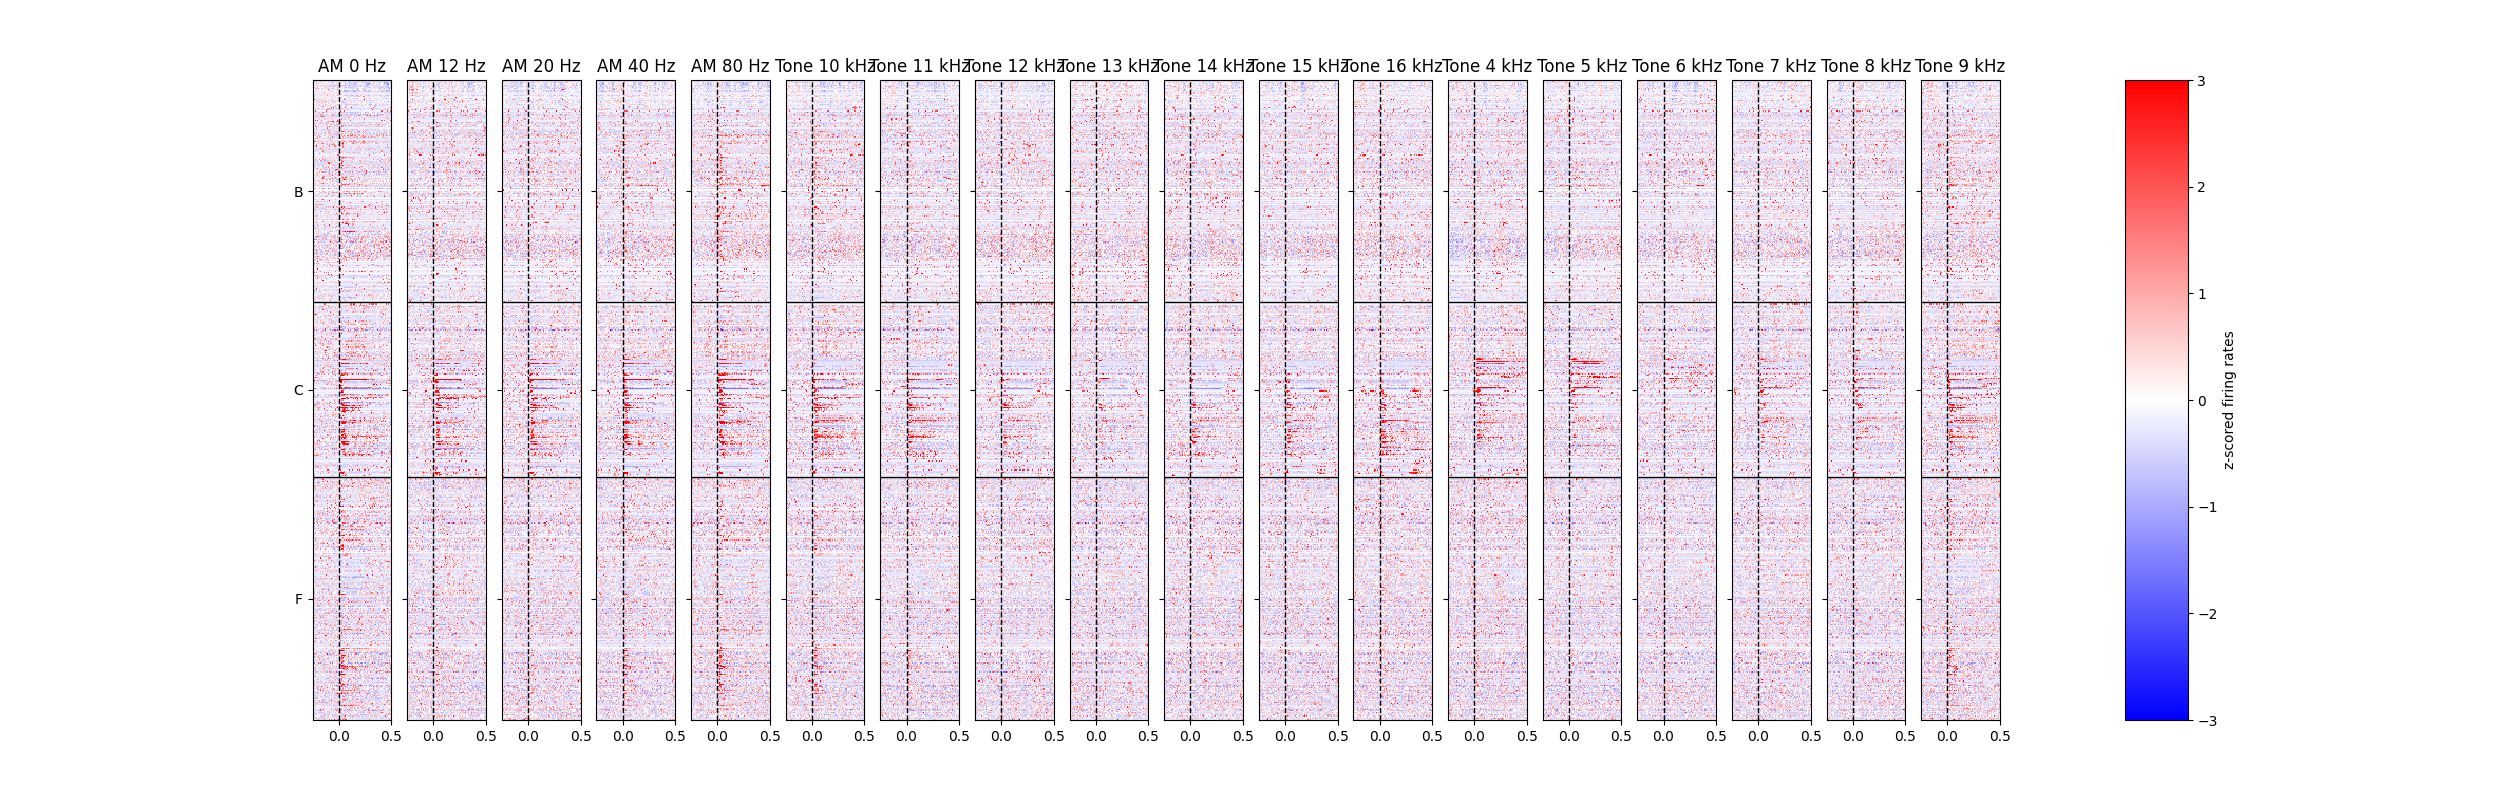

Text(0, 0.5, 'z-scored firing rates')

In [64]:
# plot heatmaps
# ordered by ascending channel number - top is tip of probe

fig,ax=plt.subplots(1,len(stimuli),figsize=(25,8))
for xx in range(0,len(stimuli)): 
    im = ax[xx].imshow(unit_frs_by_stim[:,:,xx],aspect='auto',vmin=-3,vmax=3,
                   cmap=plt.get_cmap('bwr'),interpolation='none',
                   extent=(-time_before_flash,trial_duration-time_before_flash,
                           0,unit_frs_by_stim.shape[0]))
    
    ax[xx].axvline(0,color='k',linestyle='--',linewidth=1)
    ax[xx].set_title(stimuli[xx])
    ax[xx].set_xlim(-0.25,0.5)
    ax[xx].hlines(unit_frs_by_stim.shape[0]-probe_borders,xmin=-0.5,xmax=1.5,
                   color='k',linewidth=1)
    ax[xx].set_yticks(unit_frs_by_stim.shape[0]-midpoints)
    ax[xx].set_yticklabels(probe_labels)
    if xx>0:
        ax[xx].set_yticklabels([])

# this adjusts the other plots to make space for the colorbar
fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.3) 
cax = plt.axes([0.85, 0.1, 0.025, 0.8])
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('z-scored firing rates')


In [147]:
# significantly affected units

pre_window=[-0.2,-0.1]
stim_window=[0.00,0.1]

unit_stim_pvals=np.zeros((len(session.good_units),len(session.trials.trialStimID.unique())))
unit_stim_pvals[:]=np.nan

stim_list=np.sort(session.trials.trialStimID.unique())

# loop over units
for u_count, (uid, unit) in enumerate(session.good_units.iterrows()):

    # loop over stimuli
    for ss,stim in enumerate(stim_list):
        
#         stim_list.append(stim)
        # test if significantly affected (100ms baseline vs. 100ms stimulus)
        stim_trials=session.trials.query('trialStimID == @stim').index
        pre_trial_da=session.trial_da.sel(trials=stim_trials, unit_id=uid,
                                          time=slice(pre_window[0],pre_window[1])).mean(dim='time')
        stim_trial_da=session.trial_da.sel(trials=stim_trials, unit_id=uid,
                                           time=slice(stim_window[0],stim_window[1])).mean(dim='time')
        if np.sum(stim_trial_da-pre_trial_da)!=0:
            h,p=st.wilcoxon(pre_trial_da,stim_trial_da,zero_method='wilcox')
        else:
            p=1
        
        unit_stim_pvals[u_count,ss]=p
        
# find N units affected by any sound stimulus vs. any vis stimulus (that's the denominator)

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packa

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packa

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packa

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packa

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packa

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there ar

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there ar

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packa

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packa

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packa

In [148]:
unit_stim_pvals

array([[3.24908411e-01, 4.73534542e-01, 1.11412562e-04, ...,
        6.60213913e-04, 5.45117055e-02, 7.32456947e-01],
       [3.91172523e-01, 6.44085407e-01, 1.10828117e-01, ...,
        7.05456986e-01, 4.04794561e-02, 7.49805073e-01],
       [6.47401437e-01, 6.32457904e-02, 6.19695562e-02, ...,
        1.91533996e-01, 6.89177490e-02, 7.65896207e-01],
       ...,
       [2.66027272e-01, 4.34397236e-01, 2.71135472e-01, ...,
        7.11428654e-01, 2.44861255e-01, 2.67782384e-01],
       [3.54112309e-02, 9.81071478e-01, 8.55148719e-01, ...,
        2.09044205e-01, 2.52340156e-01, 4.57560224e-01],
       [2.76302917e-01, 6.54720846e-01, 8.32645167e-02, ...,
        1.79712495e-01, 4.57614067e-01, 1.00000000e+00]])

In [149]:
np.sum(unit_stim_pvals<0.01,axis=0)

array([ 6,  1,  8, 12,  1, 12, 16,  9,  1, 13,  6, 24, 25])

In [150]:
stim_list

array(['catch', 'sound1', 'sound10', 'sound2', 'sound3', 'sound4',
       'sound5', 'sound6', 'sound7', 'sound8', 'sound9', 'vis1', 'vis2'],
      dtype=object)

In [151]:
np.sort(session.trials.trialStimID.unique())

array(['catch', 'sound1', 'sound10', 'sound2', 'sound3', 'sound4',
       'sound5', 'sound6', 'sound7', 'sound8', 'sound9', 'vis1', 'vis2'],
      dtype=object)